# Tutorial 2 - WaveBot Optimization
The goal of this tutorial is to show a simple example of using both outer and inner optimization loops in WecOptTool. 
Like the first tutorial, it uses the WaveBot WEC in one degree of freedom in regular waves. 
The goal is to **find the optimal keel radius** (`r2`) that maximizes the average aborbed power, while maintaining a constant volume. 
A constant volume is acheived by setting the height of the conical section (`h2`) in conjunction with the keel radius (`r2`).

This example demonstrates a complete case of the types of optimization studies WecOptTool is meant for. 
The main optimization (outer optimization loop) is to find the optimal geomtery (radius `r2`), and for each geometry considered the optimal PTO force (inner optimization loop) will be found.
The inner loop was showcased in *Tutorial 1* and uses a gradient-based optimization method, with the gradients obtained with automatic differentiation. 
The outer loop optimization is for the user to setup. 
Note however that automatic differentiation is not an option due to the presence of the inner optimization loop. 
In this example, we will do a simple *brute force* optimization using `scipy.optimize.brute`.  

![Device Diagram](https://live.staticflickr.com/65535/51751577441_515afec334_z.jpg)

In [6]:
import os
import logging
from datetime import datetime

import autograd.numpy as np
from autograd.builtins import isinstance, tuple, list, dict
import capytaine as cpy
import matplotlib.pyplot as plt
from scipy.optimize import brute

import wecopttool as wot


logging.basicConfig(level=logging.ERROR)

results_super_dir = 'results_tutorial_2'
if not os.path.exists(results_super_dir):
    os.makedirs(results_super_dir)


## Problem setup
First, we define a function for `h2` based on `r1` that maintains a constant volume. 
We see that, as expected, smaller values of `r2` require larger values of `h2` in order to maintain a constant hull volume.

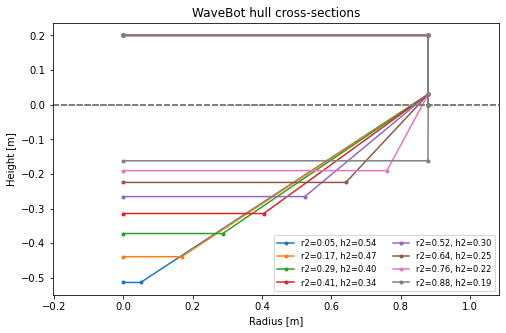

In [7]:
r1 = 0.88
r2_0 = 0.35
h2_0 = 0.37
V0 = 1/3*np.pi*h2_0*(r1**2+r2_0**2+(r1*r2_0))

r2_vals = np.linspace(0.05, 0.88*0.999, 8, endpoint=True)


def h2_from_r2(r2, V=V0, r1=r1):
    h2 = V/(1/3*np.pi*(r1**2+r2**2+(r1*r2)))
    return h2


# plot
mapres = map(h2_from_r2, r2_vals)
h2_vals = list(mapres)

fig1, ax1 = plt.subplots(figsize=(8,5))
for r2, h2 in zip(r2_vals.tolist(), h2_vals):
    _ = wot.geom.WaveBot(r2=r2, h2=h2, freeboard=0.2).plot_cross_section(
        ax=ax1, label=f"r2={r2:.2f}, h2={h2:.2f}")
ax1.legend(loc='best', fontsize='small',ncol=2)
_ = ax1.set_title('WaveBot hull cross-sections')


Next we will define an objective function for our design optimization problem. We use the same workflow illustrated in Tutorial 1 to set up a WaveBot device and solve for the optimal solution, but wrap this in a function definition which can set `r2` and (indirectly) `h2`.

In [8]:
def design_obj_fun(x):
    r2 = x[0]
    print(f"\nr2 = {r2:.2f}:")
    start_time = datetime.now()
    
    ## WEC ##
    # geometry
    h2 = h2_from_r2(r2)

    # mesh
    wb = wot.geom.WaveBot(r2=r2, h2=h2)
    mesh = wb.mesh(mesh_size_factor=0.5)

    # capytaine floating body (mesh + DOFs)
    fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
    fb.add_translation_dof(name="HEAVE")

    # mass & hydrostatic stiffness
    hs_data = wot.hydrostatics.hydrostatics(fb)
    mass_33 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[2, 2]
    mass = np.atleast_2d(mass_33)
    stiffness_33 = wot.hydrostatics.stiffness_matrix(hs_data)[2, 2]
    stiffness = np.atleast_2d(stiffness_33)

    # frequencies
    f0 = 0.05
    nfreq = 50

    # PTOs (additional force + constraint + objective function)
    kinematics = np.eye(fb.nb_dofs)
    pto = wot.pto.PseudoSpectralPTO(nfreq, kinematics)

    # constraints at 4x points
    nsubsteps = 4
    f_max = 2000.0

    def const_f_pto(wec, x_wec, x_opt):
        f = pto.force_on_wec(wec, x_wec, x_opt, nsubsteps)
        return f_max - np.abs(f.flatten())

    ineq_cons = {'type': 'ineq',
                 'fun': const_f_pto,
                 }
    constraints = [ineq_cons]

    # additional friction
    dissipation = 160.3

    # create WECs
    f_added = {'PTO force': pto.force_on_wec}

    my_wec = wot.WEC(fb, mass, stiffness, f0, nfreq, f_add=f_added,
                     constraints=constraints, dissipation=dissipation)

    # create save directory
    results_dir = os.path.join(results_super_dir, f"{r2:.2f}")
    if not os.path.exists(results_dir):
      os.makedirs(results_dir)

    # read BEM if available, else run & save
    fname = os.path.join(results_dir, 'bem.nc')
    if os.path.exists(fname):
        my_wec.read_bem(fname)
    else:
        my_wec.run_bem()
        my_wec.write_bem(fname)
        mesh.write(os.path.join(results_dir, f"{r2:.2f}.stl"))

    ## WAVE ##
    wfreq = 0.6
    amplitude = 0.0625
    phase = -40
    waves = wot.waves.regular_wave(f0, nfreq, wfreq, amplitude, phase)

    ## OBJECTIVE FUNCTION ##
    obj_fun = pto.average_power
    nstate_opt = pto.nstate

    ## SOLVE ##
    scale_x_wec = 1e4
    scale_x_opt = 1
    scale_obj = 1e-1
    options = {'maxiter': 1000, 'ftol': 1e-8}
    

    _, _, _, _, avg_power, _ = my_wec.solve(
        waves, obj_fun, nstate_opt, optim_options=options, 
        scale_x_opt=scale_x_opt, scale_x_wec=scale_x_wec, scale_obj=scale_obj)

    print(f'time (hh:mm:ss): {datetime.now()-start_time}')

    return avg_power


## Solve
Finally, we may call this objective function with an optimization algorithm. 
Here, a simple *brute force* optimization approach is used for illustrative purposes, but any variety of options could be applied. 
The optimization algorithm will call our objective function, which in turn will create a new WaveBot hull, run the necessary BEM calculations for the hull, and find the PTO force that provides the most absorbed power for that hull. 
This process will be conducted for the range of `r2` values that we specify.

In [9]:
# range over which to search
ranges = (slice(r2_vals[0], r2_vals[-1]+np.diff(r2_vals)[0], np.diff(r2_vals)[0]),)

# solve
res = brute(func=design_obj_fun, ranges=ranges, full_output=True,  finish=None)


r2 = 0.05:
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.6006794546579421
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
time (hh:mm:ss): 0:00:02.060156

r2 = 0.17:
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.59552364526259
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
time (hh:mm:ss): 0:00:02.291601

r2 = 0.29:
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5942559883503795
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
time (hh:mm:ss): 0:00:02.655772

r2 = 0.41:
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5922480417468277
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
time (hh:mm:ss

## Results
From a quick plot of the results, we see that the power absorption (where negative power is power absorbed by the device) generally improves for smaller values of `r2`.
It is also clear that when the WEC is cylindrical (where `r2=0.88`), power absorption is reduced.

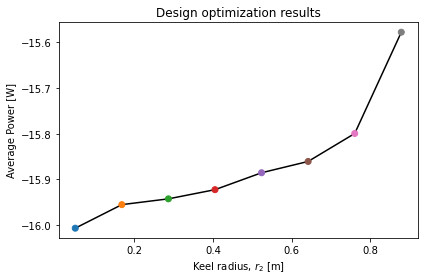

In [10]:
fig2, ax2 = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(res[2])]

ax2.plot(res[2], res[3], 'k', zorder=0)
ax2.scatter(res[2], res[3], c=colors, zorder=1)

ax2.set_xlabel('Keel radius, $r_2$ [m]')
ax2.set_ylabel('Average Power [W]')
ax2.set_title('Design optimization results')
fig2.tight_layout()

plt.show()